<a href="https://colab.research.google.com/github/chldmstj/CHAI/blob/master/lecture_mosaic_project_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 학습 완료한 파일 연동을 위한 drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 학습 완료한 RetinaNet 압축해제
!unzip "/content/drive/My Drive/lecture_mosaic_project_data.zip" -d "/content"

Archive:  /content/drive/My Drive/lecture_mosaic_project_data.zip
   creating: /content/lecture_mosaic_project_data/dataset/
  inflating: /content/lecture_mosaic_project_data/dataset/bts.jpg  
  inflating: /content/lecture_mosaic_project_data/dataset/radio.mp4  
  inflating: /content/lecture_mosaic_project_data/dataset/radio_frame.PNG  
  inflating: /content/lecture_mosaic_project_data/dataset/radio_frame2.PNG  
   creating: /content/lecture_mosaic_project_data/facenet/
  inflating: /content/lecture_mosaic_project_data/facenet/facenet_keras.h5  
   creating: /content/lecture_mosaic_project_data/retinaface/
  inflating: /content/lecture_mosaic_project_data/retinaface/saved_model.pb  
   creating: /content/lecture_mosaic_project_data/retinaface/variables/
  inflating: /content/lecture_mosaic_project_data/retinaface/variables/variables.data-00000-of-00001  
  inflating: /content/lecture_mosaic_project_data/retinaface/variables/variables.index  


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

import numpy as np
from numpy import dot
from numpy.linalg import norm

import os
import sys
import cv2
from google.colab.patches import cv2_imshow
import timeit

1. faceNet model, rentinaNet model load

In [ ]:
facenet_model = load_model('/content/lecture_mosaic_project_data/facenet/facenet_keras.h5')

In [ ]:
retina = load_model('/content/lecture_mosaic_project_data/retinaface')

2. retina 모델이 정상적으로 load 되어 있는지 확인, bts.jpg 파일 이용

In [ ]:
# 이미지 파일을 load, 모델에서 사용할 수 있는 형태로 변환
img = cv2.imread('/content/lecture_mosaic_project_data/dataset/bts.jpg')

In [ ]:
img = img.astype(np.float32)

In [ ]:
# retina 모델에 load 한이미지 전달하여 예측 수행
face_detection = retina(np.expand_dims(img, axis=0)).numpy()

In [ ]:
face_detection.shape

(7, 16)

3. facenet 모델이 정상적으로 load되어 있는지 확인
* 이미지 load 및 전처리
* 높이 정보, 넓이 정보 저장
* retina 이미지 전달하여 예측 수행
* 예측 결과에 높이 정보와 넓이 정보를 이용하여 실제 좌표 생성
* cv2.rectangle() API를 이용하여 실제 bbox 생성하여 이미지 출력
* 조인성 얼굴 선택 후 file(target_img.png) 로 write (cv2.imwrite())

In [ ]:
image = cv2.imread('/content/lecture_mosaic_project_data/dataset/radio_frame2.PNG')

In [ ]:
input_image = image.copy()

In [ ]:
input_image = input_image.astype(np.float32)

In [ ]:
face_detections = retina(np.expand_dims(input_image, axis=0)).numpy()

In [ ]:
face_detections.shape

(4, 16)

In [ ]:
face_detections[0]

array([0.37776938, 0.36658618, 0.42525318, 0.50201917, 0.3835992 ,
       0.41851053, 0.39487365, 0.41922435, 0.38142157, 0.4475067 ,
       0.3887037 , 0.4701377 , 0.39705625, 0.47037587, 1.        ,
       0.9999393 ], dtype=float32)

In [ ]:
img_height = input_image.shape[0]
img_width = input_image.shape[1]

In [ ]:
boxes=[]

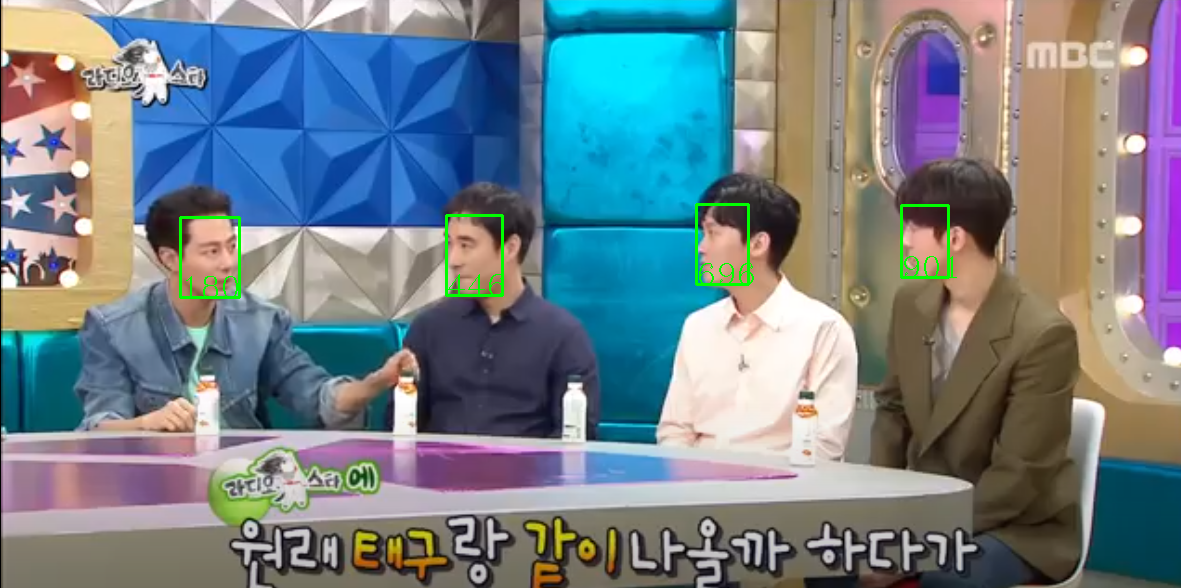

In [ ]:
for face in face_detections:
  x1, y1, x2, y2 = int(face[0] * img_width), int(face[1] * img_height), \
                    int(face[2] * img_width), int(face[3] * img_height)
  box=(abs(x1),abs(y1),abs(x2),abs(y2))
  boxes.append(box)
  cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
  cv2.putText(image,'{}'.format(str(box[0])),(box[0],box[3]),3,1,(0,255,0))
cv2_imshow(image)

In [ ]:
boxes

[(446, 215, 502, 295),
 (180, 217, 239, 297),
 (696, 204, 748, 284),
 (901, 205, 948, 277)]

In [ ]:
target_img = input_image[boxes[1][1]:boxes[1][3],
                         boxes[1][0]:boxes[1][2]]

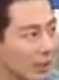

In [ ]:
cv2_imshow(target_img)

In [ ]:
cv2.imwrite('target_img.png', target_img)

True

* target_img.png 파일을 load 해서 model이 요구하는 형태로 변환
  * shape : (1, 160, 160, 3)
  * dtype : float32
  * sacle : stanardization (across channels)
* faceNet model에 data 전달하여 예측 수행

In [ ]:
frame = cv2.imread('target_img.png')

In [ ]:
REQUIRED_SIZE = (160, 160)
frame = cv2.resize(frame, REQUIRED_SIZE).astype(np.float32)

In [ ]:
mean, std = frame.mean(), frame.std()

In [ ]:
frame = (frame-mean)/std

In [ ]:
y_pred = facenet_model(np.expand_dims(frame, axis=0))

In [ ]:
y_pred[0].numpy().shape

(128,)

In [ ]:
mosaic_video='/content/lecture_mosaic_project_data/dataset/radio.mp4'
target_img = 'target_img.png'
save_videoname = 'radio_mosaic.mp4'

### 모자이크 서비스 구현
1. 동영상 파일을 load 한 프레임씩 이미지 정보 추출(30 frame) - matplotlib 이용하여 추출된 이미지 출력
2. retinaNet 모델을 이용하여 매 프레임 별로 출현하는 얼굴 정보 추출
3. faceNet 모델을 이용하여 매 프레임 별로 출현한 얼굴의 임베딩값 추출
4. 타겟 얼굴의 임베딩 값과 매 프레임 별로 추출된 임베딩 값들을 cosine 유사도를 계산하여 타겟 얼굴을 제외한 나머지 얼굴들에 대해서 모자이크  
> * 타겟 얼굴의 임베딩 값과 매 프레임 별로 추출된 임베딩 값들을 cosine 유사도를 계산
> * 유사도가 가장 높은 얼굴의 경우 threshold 값을 넘는지 체크
> * 유사도가 가장 높으면서 threshold 값을 넘는 얼굴은 원래 이미지 사용
> * 유사도가 가장 높지 않거나 threshold 값을 넘지 않는 얼굴은 모자이크 처리

In [ ]:
# 타겟 얼굴(조인성)의 임베딩값 계산
target_embedding = y_pred[0].numpy()

In [ ]:
i_frame = 0
cap = cv2.VideoCapture(mosaic_video)

width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
#재생할 파일의 높이 얻기
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
#재생할 파일의 프레임 레이트 얻기
fps = cap.get(cv2.CAP_PROP_FPS)

#저장할 비디오 코덱
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

#파일 stream 생성
out = cv2.VideoWriter(save_videoname, fourcc, fps, (int(width), int(height)))

while cap.isOpened():
  ret, frame = cap.read()

  if not ret or i_frame > 350:
    break
  
  orig = frame.copy()

  input_image = frame.astype(np.float32)
  img_height = input_image.shape[0]
  img_width = input_image.shape[1]

  face_detections = retina(np.expand_dims(input_image, axis=0)).numpy()

  embedding_box_dict = {}

  for i, face in enumerate(face_detections):
    x1, y1, x2, y2 = int(face[0] * img_width), int(face[1] * img_height), \
                    int(face[2] * img_width), int(face[3] * img_height)
    box = (abs(x1),abs(y1),abs(x2),abs(y2))
    
    face_tensor = orig[box[1]:box[3], box[0]:box[2]]
    face_img = face_tensor.copy()
    face_tensor = cv2.resize(face_tensor, REQUIRED_SIZE).astype(np.float32)

    mean, std = face_tensor.mean(), face_tensor.std()
    face_tensor = (face_tensor - mean) / std

    embedding = facenet_model(np.expand_dims(face_tensor, axis=0)).numpy()
    embedding_box_dict[i] = {'box' : box, 'embedding': embedding}

  distance_arraies=[]

  for i in range(0, len(embedding_box_dict)):
    distance = dot(embedding_box_dict[i]['embedding'], target_embedding)\
               /(norm(embedding_box_dict[i]['embedding']) * norm(target_embedding))
    distance_arraies.append(distance)

  most_simularity_index = np.array(distance_arraies).argmax()

  if distance_arraies[most_simularity_index] > 0.7:
    target_index = most_simularity_index
  else:
    target_index = None

  for index  in embedding_box_dict:
    if index != target_index:
      box = embedding_box_dict[index]['box']
      x1,y1, x2,y2 = box[0], box[1], box[2], box[3]
      orig[y1:y2, x1:x2] = cv2.blur(orig[y1:y2, x1:x2], (25,25))

  i_frame += 1

  # 인식된 이미지 파일로 저장
  out.write(orig)

  if i_frame % 50 == 0:
    print("{} frame".format(i_frame))

cap.release()
out.release()

50 frame
100 frame
150 frame
200 frame
250 frame
300 frame
350 frame
